## Detecting Suspicious Language in Job Postings Using N-Gram Analysis

In this notebook, we aim to uncover linguistic patterns and suspicious phrases within a large dataset of job descriptions.

We start by working with the raw dataset (`all_job_postings.csv`) that contains both **fraudulent** and **legitimate** job postings.

### What We Do:

1. **Text Cleaning**: We preprocess the `description` field by lowercasing, removing numbers, punctuation, and stopwords.
2. **N-Gram Analysis (Bigrams)**: We use `CountVectorizer` to extract frequently occurring **2-word phrases (bigrams)** from all job descriptions.
3. **Visualizations**:
   - **Bar Charts**: Show the top 20 most common bigrams.
   - **Word Clouds**: Display the top 100 bigrams visually (bigger = more frequent).

This gives us a bird's-eye view of the most common language used in job descriptions — setting the stage for comparing fake vs. real job patterns.


In [10]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import string


In [3]:
#load the dataset
df = pd.read_csv("../1_datasets/aegean_raw_data/all_job_postings.csv")
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text)
    return text


df["clean_description"] = df["description"].apply(clean_text)


In [5]:
# Create a vectorizer for bigrams (n=2)
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")

# Fit and transform the cleaned descriptions
X = vectorizer.fit_transform(df["clean_description"])

# Sum counts for each bigram
sum_bigrams = X.sum(axis=0)

# Create a frequency table
bigram_freq = [
    (word, sum_bigrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()
]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

# Display top 20 bigrams
for bigram, freq in bigram_freq[:20]:
    print(f"{bigram}: {freq}")


customer service: 2688
social media: 1428
join team: 1017
team members: 1001
ideal candidate: 934
communication skills: 933
years experience: 814
business development: 738
student loanscredit: 726
monthly cost: 723
play kids: 715
kids paid: 715
right candidate: 693
usd monthly: 687
cost livinghousing: 677
include limited: 677
work closely: 663
asia usd: 658
development team: 644
love travel: 635


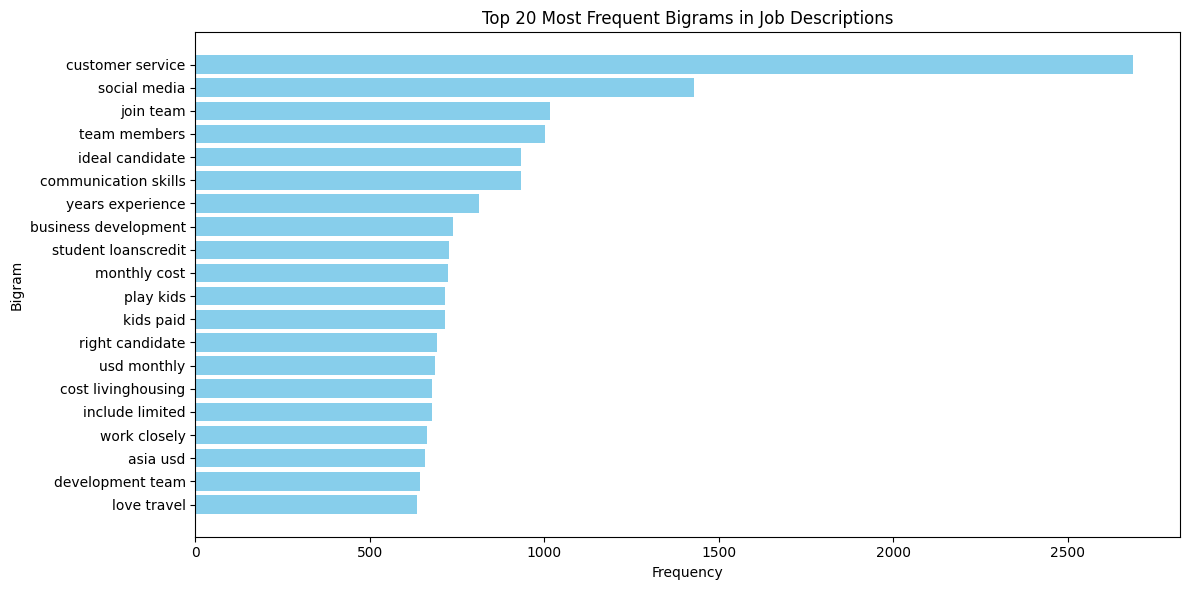

In [6]:
import matplotlib.pyplot as plt

# Take top 20 bigrams
top_bigrams = bigram_freq[:20]

# Separate into labels and values
bigrams, freqs = zip(*top_bigrams)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(bigrams[::-1], freqs[::-1], color="skyblue")
plt.title("Top 20 Most Frequent Bigrams in Job Descriptions")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()


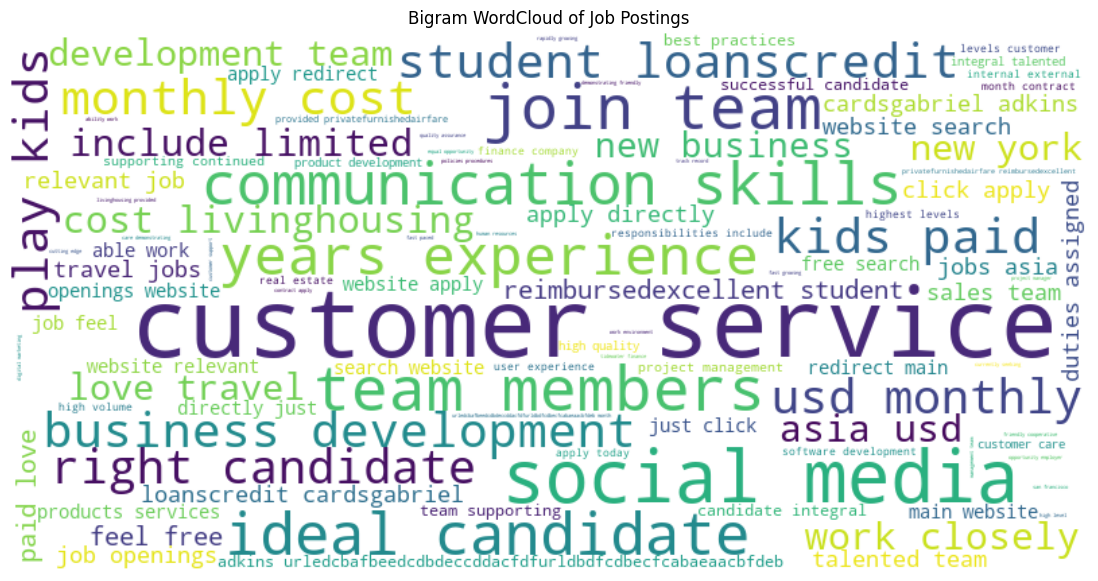

In [8]:
from wordcloud import WordCloud

# Create a dict for wordcloud
bigram_dict = dict(bigram_freq[:100])  # top 100

# Generate wordcloud
wc = WordCloud(
    width=800, height=400, background_color="white"
).generate_from_frequencies(bigram_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Bigram WordCloud of Job Postings")
plt.show()


## Fake vs. Real Jobs: N-Gram Comparison

Now, we separate the dataset into **fake (fraudulent)** and **real (legitimate)** job postings.

We analyze each group individually to:

- Identify suspicious or "scammy" bigrams in fake job descriptions (e.g., "quick hire", "limited spots").
- Compare these with the bigrams found in real job postings, which may include more structured, professional language.

To identify the **linguistic fingerprints** of fraudulent job posts in contrast to real ones — and explore how NLP can detect these differences using simple N-Gram patterns.


In [15]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


We first start by doping any missing vals 


We first start by doping any missing vals and 

In [13]:
# Drop missing descriptions (very important!)
df = df.dropna(subset=["description"])


In [14]:
# Create separate DataFrames
fake_jobs = df[df["fraudulent"] == 1].copy()
real_jobs = df[df["fraudulent"] == 0].copy()

print(f"Fake jobs: {len(fake_jobs)}")
print(f"Real jobs: {len(real_jobs)}")


Fake jobs: 865
Real jobs: 17014


we'll clean the description field by:
Lowercasing , Removing numbers, removing punctuation ,Collapsing extra whitespace

In [16]:
# Download stopwords from NLTK
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))


def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"\d+", "", text)  # remove numbers
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # remove punctuation
    text = re.sub(r"\s+", " ", text)  # remove extra spaces
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Clean the descriptions
fake_jobs["clean_description"] = fake_jobs["description"].apply(clean_text)
real_jobs["clean_description"] = real_jobs["description"].apply(clean_text)


Use CountVectorizer with ngram_range=(2,2) to extract common 2-word phrases across all job descriptions. This gives us an overview of frequently repeated language.

In [18]:
# Get top bigrams function
def get_top_bigrams(text_series, n=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
    X = vectorizer.fit_transform(text_series)
    sum_words = X.sum(axis=0)
    bigrams_freq = [
        (word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()
    ]
    return sorted(bigrams_freq, key=lambda x: x[1], reverse=True)[:n]


# Extract top bigrams
fake_bigrams = get_top_bigrams(fake_jobs["clean_description"])
real_bigrams = get_top_bigrams(real_jobs["clean_description"])


In [19]:
# Convert to dictionaries for word clouds
fake_dict = dict(fake_bigrams)
real_dict = dict(real_bigrams)


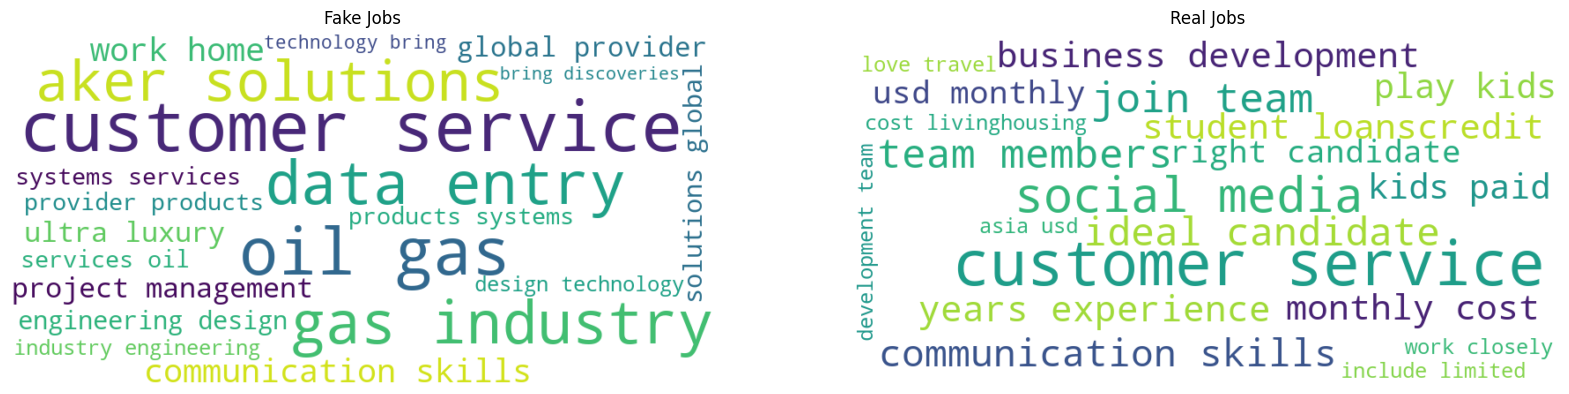

In [21]:
# Visualize side-by-side
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].imshow(
    WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(fake_dict),
    interpolation="bilinear",
)
axs[0].axis("off")
axs[0].set_title("Fake Jobs")

axs[1].imshow(
    WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(real_dict),
    interpolation="bilinear",
)
axs[1].axis("off")
axs[1].set_title("Real Jobs")

plt.show()


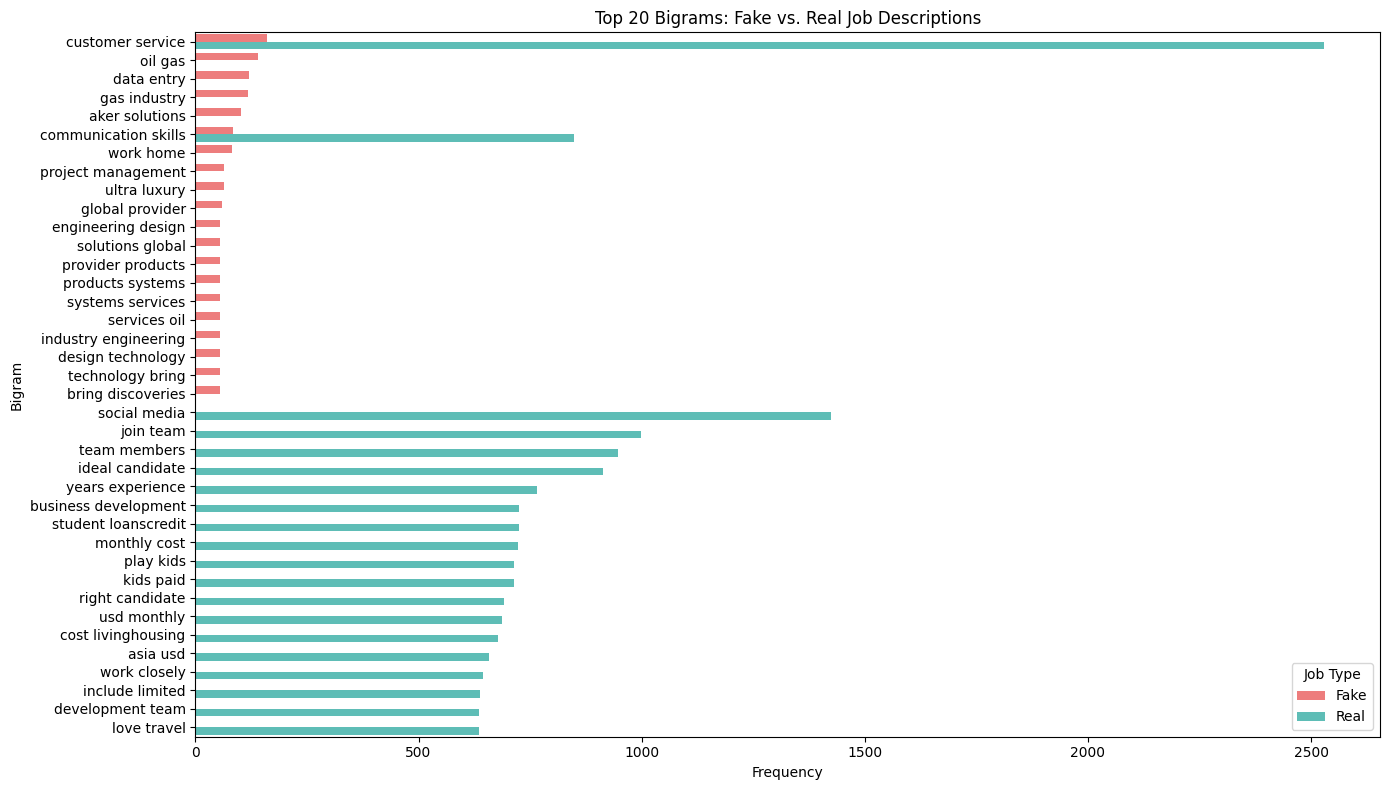

In [22]:
import seaborn as sns
import pandas as pd

# Convert to DataFrames
fake_df = pd.DataFrame(fake_bigrams, columns=["bigram", "freq"])
fake_df["type"] = "Fake"

real_df = pd.DataFrame(real_bigrams, columns=["bigram", "freq"])
real_df["type"] = "Real"

# Combine for side-by-side chart
combined_df = pd.concat([fake_df, real_df])

# Create barplot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=combined_df,
    x="freq",
    y="bigram",
    hue="type",
    orient="h",
    palette=["#FF6B6B", "#4ECDC4"],
)
plt.title("Top 20 Bigrams: Fake vs. Real Job Descriptions")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.legend(title="Job Type")
plt.tight_layout()
plt.show()
